In [1]:
import numpy as np
import pickle

from scipy.stats import spearmanr
import itertools

import seaborn as sns
import matplotlib.pyplot as plt

# load explanations

In [2]:
#load explanations

#lime
#TODO

#kernelshap
model_names = ['logistic', 'gb', 'rf', 'nn', 'nn_logistic']
filenames = {'logistic': 'explanations/expl_kernelshap_logistic.pkl', 
                'gb': 'explanations/expl_kernelshap_gb.pkl', 
                'rf': 'explanations/expl_kernelshap_rf.pkl', 
                'nn': 'explanations/expl_kernelshap_nn.pkl',
                'nn_logistic': 'explanations/expl_kernelshap_nn_logistic.pkl'}
attr_kernelshap = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}

#vanillagrad
model_names = ['nn', 'nn_logistic']
filenames = {'nn': 'explanations/expl_vanillagrad_nn.pkl',
                'nn_logistic': 'explanations/expl_vanillagrad_nn_logistic.pkl'}
attr_vanillagrad = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}

#gradient*input
model_names = ['nn', 'nn_logistic']
filenames = {'nn': 'explanations/expl_gradtinput_nn.pkl',
                'nn_logistic': 'explanations/expl_gradtinput_nn_logistic.pkl'}
attr_gradtinput = {m: pickle.load(open(filenames[m], 'rb')) for m in model_names}

#integrated gradients
#TODO

#smoothgrad
#TODO


# calculate rank correlations + plot

In [3]:
def calc_rank_corr_two_methods(attr1, attr2):
    '''
    attr1: np.array, n x p
    attr2: np.array, n x p
    '''
    #calculate feature ranks
    ranks1 = np.argsort(-np.abs(attr1), axis=1)
    ranks2 = np.argsort(-np.abs(attr2), axis=1)

    #calculate rank correlation for each data point
    #https://stackoverflow.com/questions/44947030/how-to-get-scipy-stats-spearmanra-b-compute-correlation-only-between-variable
    corrs = []
    for row in range(ranks1.shape[0]):
        rho, _ = spearmanr(ranks1[row, :], ranks2[row, :])
        corrs.append(rho)
        
    return np.array(corrs) #rank correlations for each datapoint




In [4]:
def calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs):
    
    num_expl_methods = len(expl_methods_attrs)
    
    #initiate correlation matrix
    corr_matrix = np.zeros([num_expl_methods, num_expl_methods])
    
    #fill correlation matrix with average rank correlation
    for a, b in itertools.combinations_with_replacement(range(num_expl_methods), 2):
        print(f'calculating {expl_methods_names[a]} ({a}) and {expl_methods_names[b]} ({b})')
        corrs = calc_rank_corr_two_methods(expl_methods_attrs[a], expl_methods_attrs[b]) #rank correlations for each datapoint
        corr_matrix[a, b] = np.mean(corrs) #average rank correlation
        corr_matrix[b, a] = corr_matrix[a, b]
        
    return corr_matrix
    
    

In [5]:
def plot_corr_matrix(corr_matrix, plot_path):
    mask = np.invert(np.tril(np.ones_like(corr_matrix, dtype=bool))) #mask for upper triangle
    cmap = sns.color_palette('vlag', as_cmap=True) #diverging colormap
    labels = ['LIME', 'KernelSHAP', 'Grad', 'Grad*Input', 'IntGrad', 'SmoothGRAD'] #x and y tick labels
    
    #heatmap
    plt.figure(figsize=(15, 7))
    sns.heatmap(corr_matrix, mask=mask, cmap=cmap, 
                vmin=-1, vmax=1, center=0,
                xticklabels=labels, yticklabels=labels,
                square=True, linewidths=.5, cbar_kws={'shrink': 0.995})
    plt.yticks(rotation=0)
    plt.savefig(plot_path, facecolor='white', transparent=False)

### NN

In [6]:
#calculate rank correlation matrix 

expl_methods_names = {0: 'LIME',
                1: 'KernelSHAP', 
                2: 'Grad',
                3: 'Grad*Input',
                4: 'IntGrad',
                5: 'SmoothGRAD'}

filler = np.zeros((attr_kernelshap['nn'].shape[0], attr_kernelshap['nn'].shape[1]))

expl_methods_attrs = {0: filler,
                      1: attr_kernelshap['nn'], 
                      2: attr_vanillagrad['nn'],
                      3: attr_gradtinput['nn'],
                      4: filler,
                      5: filler}

corr_matrix_nn = calc_rank_corr_all_methods(expl_methods_names, expl_methods_attrs)

calculating LIME (0) and LIME (0)
calculating LIME (0) and KernelSHAP (1)
calculating LIME (0) and Grad (2)
calculating LIME (0) and Grad*Input (3)
calculating LIME (0) and IntGrad (4)
calculating LIME (0) and SmoothGRAD (5)
calculating KernelSHAP (1) and KernelSHAP (1)
calculating KernelSHAP (1) and Grad (2)
calculating KernelSHAP (1) and Grad*Input (3)
calculating KernelSHAP (1) and IntGrad (4)
calculating KernelSHAP (1) and SmoothGRAD (5)
calculating Grad (2) and Grad (2)
calculating Grad (2) and Grad*Input (3)
calculating Grad (2) and IntGrad (4)
calculating Grad (2) and SmoothGRAD (5)
calculating Grad*Input (3) and Grad*Input (3)
calculating Grad*Input (3) and IntGrad (4)
calculating Grad*Input (3) and SmoothGRAD (5)
calculating IntGrad (4) and IntGrad (4)
calculating IntGrad (4) and SmoothGRAD (5)
calculating SmoothGRAD (5) and SmoothGRAD (5)


In [7]:
#!!!!!temporary
#fill missing methods with 0
#TODO -- remove

filler_idx = [0, 4, 5]

for idx in filler_idx:
    corr_matrix_nn[idx, :] = 0
    corr_matrix_nn[:, idx] = 0

np.fill_diagonal(corr_matrix_nn, 1)

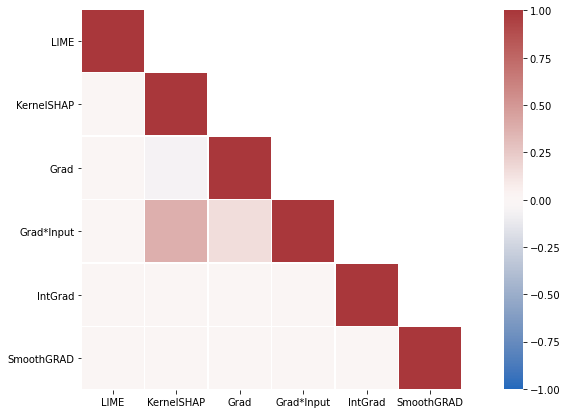

In [8]:
#plot rank correlation matrix 
corr_matrix=corr_matrix_nn
plot_path='rank_correlation_nn'
plot_corr_matrix(corr_matrix, plot_path)

### logistic

### RF

### GB